# Tool Call Embeddings Visualization

This notebook creates embeddings for full tool calls (tool name + parameters) from the test data and visualizes them to understand tool similarities and clusters.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from typing import List, Dict

# Try to import UMAP if available
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available. Install with: pip install umap-learn")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

/scratch4/home/akrik/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

# Load test data
test_data_path = '../data/ablation/test_data.jsonl'
tool_calls = []
tool_call_labels = []  # Track which tool each call belongs to
queries = []

print(f"Loading tool calls from {test_data_path}...")
with open(test_data_path, 'r') as f:
    for line in f:
        data = json.loads(line.strip())
        tool_call = data['ground_truth']
        tool_name = data['tool']
        query = data.get('query', '')
        
        tool_calls.append(tool_call)
        tool_call_labels.append(tool_name)
        queries.append(query)

print(f"Loaded {len(tool_calls)} tool calls")
print(f"\nSample tool calls:")
for i, (call, label) in enumerate(zip(tool_calls[:5], tool_call_labels[:5])):
    print(f"  {i+1}. [{label}] {call}")

# Get unique tools
from ablation.tool_schemas import TOOL_SCHEMAS
tool_names = list(TOOL_SCHEMAS.keys())
num_tools = len(tool_names)
print(f"\nNumber of unique tools: {num_tools}")
print(f"Tool names: {tool_names}")

Loading tool calls from ../data/ablation/test_data.jsonl...
Loaded 100 tool calls

Sample tool calls:
  1. [send_email] send_email(to='kathryn88@example.org', subject='Food affect upon these.', body='Please review the attached document and provide feedback by end of week.')
  2. [calculate] calculate(expression='(5 + 3) * 2')
  3. [database_query] database_query(sql='SELECT * FROM transactions LIMIT 21', timeout=58)
  4. [database_query] database_query(sql='SELECT * FROM products LIMIT 80', timeout=10)
  5. [search] search(query='climate change', max_results=14, date_filter=DateRange(from_date='2025-07-24', to_date='2026-01-13'))

Number of unique tools: 6
Tool names: ['search', 'calculate', 'database_query', 'send_email', 'web_fetch', 'file_read']


In [5]:
import re
from transformers import AutoTokenizer, AutoModel, T5EncoderModel, AutoConfig

class ToolCallEmbeddingEncoder(nn.Module):
    """
    Encodes full tool calls (tool name + parameters) into embeddings.
    Uses Qwen model to capture semantic meaning of parameters.
    """
    
    def __init__(self, d_model: int, base_model_name: str = "google/flan-t5-base"):
        super().__init__()
        self.d_model = d_model
        self.base_model_name = base_model_name
        
        print(f"Loading Qwen model: {base_model_name}")
        # Load Qwen tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        self.encoder = T5EncoderModel.from_pretrained(base_model_name)
        
        # Get the hidden size from the model config
        if hasattr(self.encoder.config, 'hidden_size'):
            encoder_dim = self.encoder.config.hidden_size
        elif hasattr(self.encoder.config, 'n_embd'):
            encoder_dim = self.encoder.config.n_embd
        else:
            # Fallback: try to get from model
            encoder_dim = self.encoder.config.d_model if hasattr(self.encoder.config, 'd_model') else 2048
        
        # Project to desired dimension
        self.projection = nn.Linear(encoder_dim, d_model)
        
        # Set pad token if not present
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
    
    def encode_tool_call(self, tool_call_str: str) -> torch.Tensor:
        """
        Encode a tool call string into an embedding using Qwen.
        
        Args:
            tool_call_str: String like "search(query='machine learning', max_results=10)"
            
        Returns:
            (d_model,) tensor
        """
        # Tokenize the tool call
        inputs = self.tokenizer(
            tool_call_str,
            return_tensors="pt",
            truncation=True,
            max_length=256,
            padding=False
        )
        
        # Move to same device as model
        device = next(self.encoder.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            # Get model outputs
            outputs = self.encoder(**inputs, output_hidden_states=True)
            
            # Use mean pooling over all token embeddings (excluding padding)
            # For decoder-only models, we use the last hidden state
            hidden_states = outputs.hidden_states[-1]  # Last layer
            
            # Mean pooling over sequence length (excluding padding)
            attention_mask = inputs.get('attention_mask', None)
            if attention_mask is not None:
                # Expand mask to match hidden states dimensions
                mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
                # Sum embeddings and divide by number of non-padding tokens
                sum_embeddings = torch.sum(hidden_states * mask_expanded, dim=1)
                sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
                embedding = sum_embeddings / sum_mask
            else:
                # Simple mean if no attention mask
                embedding = hidden_states.mean(dim=1)
            
            # Project to desired dimension
            embedding = self.projection(embedding.squeeze(0))
        
        return embedding
    
    def encode_tool_calls(self, tool_call_strings: List[str]) -> torch.Tensor:
        """
        Encode multiple tool calls.
        
        Args:
            tool_call_strings: List of tool call strings
            
        Returns:
            (batch_size, d_model) tensor
        """
        embeddings = []
        for tool_call in tool_call_strings:
            emb = self.encode_tool_call(tool_call)
            embeddings.append(emb)
        return torch.stack(embeddings)

In [6]:
# Create tool call encoder using Qwen
# Using same dimension as typical transformer models (768 is common, but we'll use 512 for visualization)
d_model = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Creating tool call embedding encoder using Qwen (d_model={d_model})...")
print(f"Device: {device}")
tool_call_encoder = ToolCallEmbeddingEncoder(d_model=d_model, base_model_name="google/flan-t5-base")
# Move model and projection to device
tool_call_encoder.encoder.to(device)
tool_call_encoder.projection.to(device)
tool_call_encoder.eval()

# Encode all tool calls from test data
print(f"\nEncoding {len(tool_calls)} tool calls...")
tool_call_embeddings_list = []
for i, tool_call in enumerate(tool_calls):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i+1}/{len(tool_calls)}")
    emb = tool_call_encoder.encode_tool_call(tool_call).cpu().numpy()
    tool_call_embeddings_list.append(emb)

tool_call_embeddings = np.array(tool_call_embeddings_list)
print(f"\nTool call embeddings shape: {tool_call_embeddings.shape}")
print(f"Embedding stats:")
print(f"  Mean: {tool_call_embeddings.mean():.6f}")
print(f"  Std: {tool_call_embeddings.std():.6f}")
print(f"  Min: {tool_call_embeddings.min():.6f}")
print(f"  Max: {tool_call_embeddings.max():.6f}")

Creating tool call embedding encoder using Qwen (d_model=512)...
Device: cuda
Loading Qwen model: google/flan-t5-base

Encoding 100 tool calls...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

Tool call embeddings shape: (100, 512)
Embedding stats:
  Mean: 0.000827
  Std: 0.041623
  Min: -0.154752
  Max: 0.155614


## 2. PCA Visualization (2D)

Let's visualize the tool call embeddings using PCA to see how similar tool calls cluster together.

PCA Explained Variance Ratio: [0.2894751 0.2014134]
Total Explained Variance: 0.4909


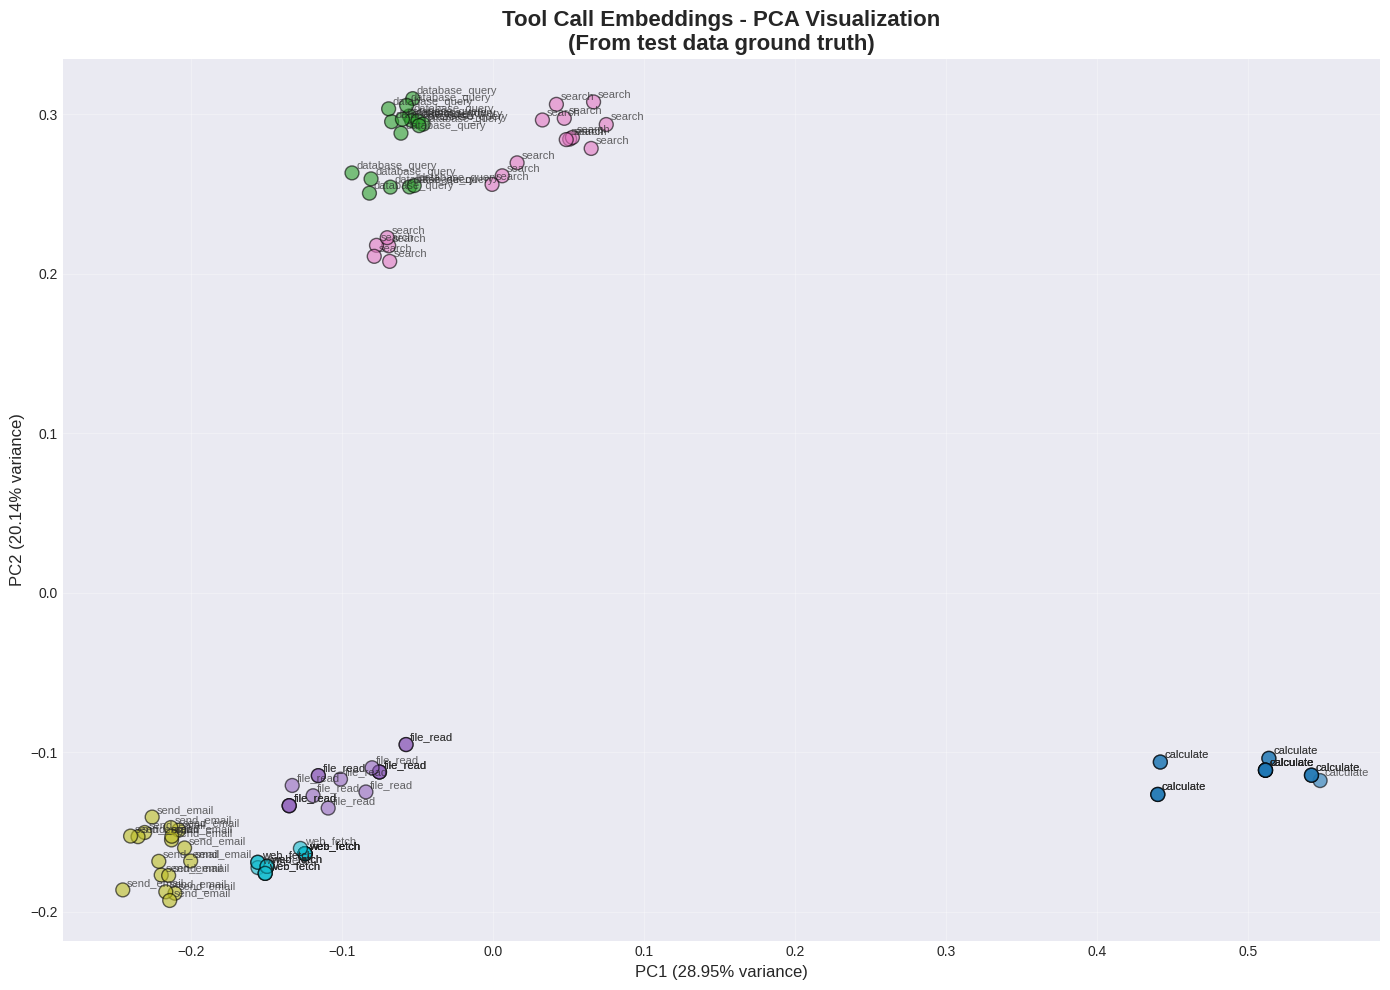

In [7]:
# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(tool_call_embeddings)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum():.4f}")

# Create color mapping for tools
unique_tools = list(set(tool_call_labels))
color_map = {tool: i for i, tool in enumerate(sorted(unique_tools))}
colors = [color_map[label] for label in tool_call_labels]

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    s=100,
    alpha=0.6,
    c=colors,
    cmap='tab10',
    edgecolors='black',
    linewidths=1
)

# Add labels (show tool name, not full call to avoid clutter)
for i, label in enumerate(tool_call_labels):
    ax.annotate(
        label,
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        alpha=0.7
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title('Tool Call Embeddings - PCA Visualization\n(From test data ground truth)', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. t-SNE Visualization (2D)

t-SNE is better at preserving local structure and showing clusters.

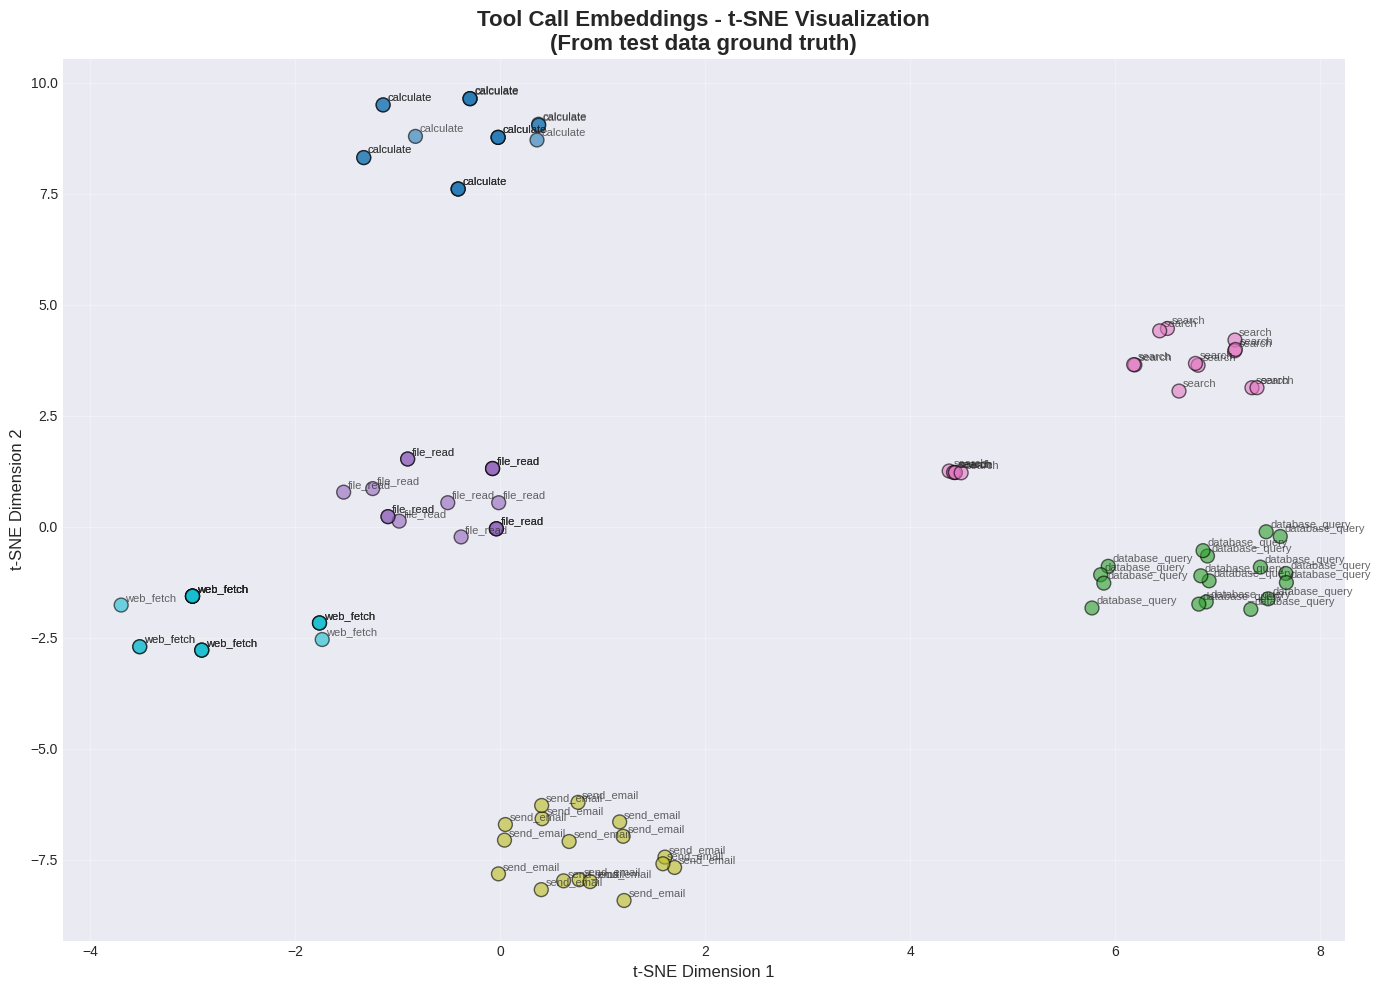

In [8]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(tool_calls) - 1))
embeddings_2d_tsne = tsne.fit_transform(tool_call_embeddings)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    embeddings_2d_tsne[:, 0],
    embeddings_2d_tsne[:, 1],
    s=100,
    alpha=0.6,
    c=colors,
    cmap='tab10',
    edgecolors='black',
    linewidths=1
)

# Add labels
for i, label in enumerate(tool_call_labels):
    ax.annotate(
        label,
        (embeddings_2d_tsne[i, 0], embeddings_2d_tsne[i, 1]),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        alpha=0.7
    )

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Tool Call Embeddings - t-SNE Visualization\n(From test data ground truth)', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. UMAP Visualization (2D)

UMAP often provides better cluster separation than t-SNE.

/scratch4/home/akrik/base/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


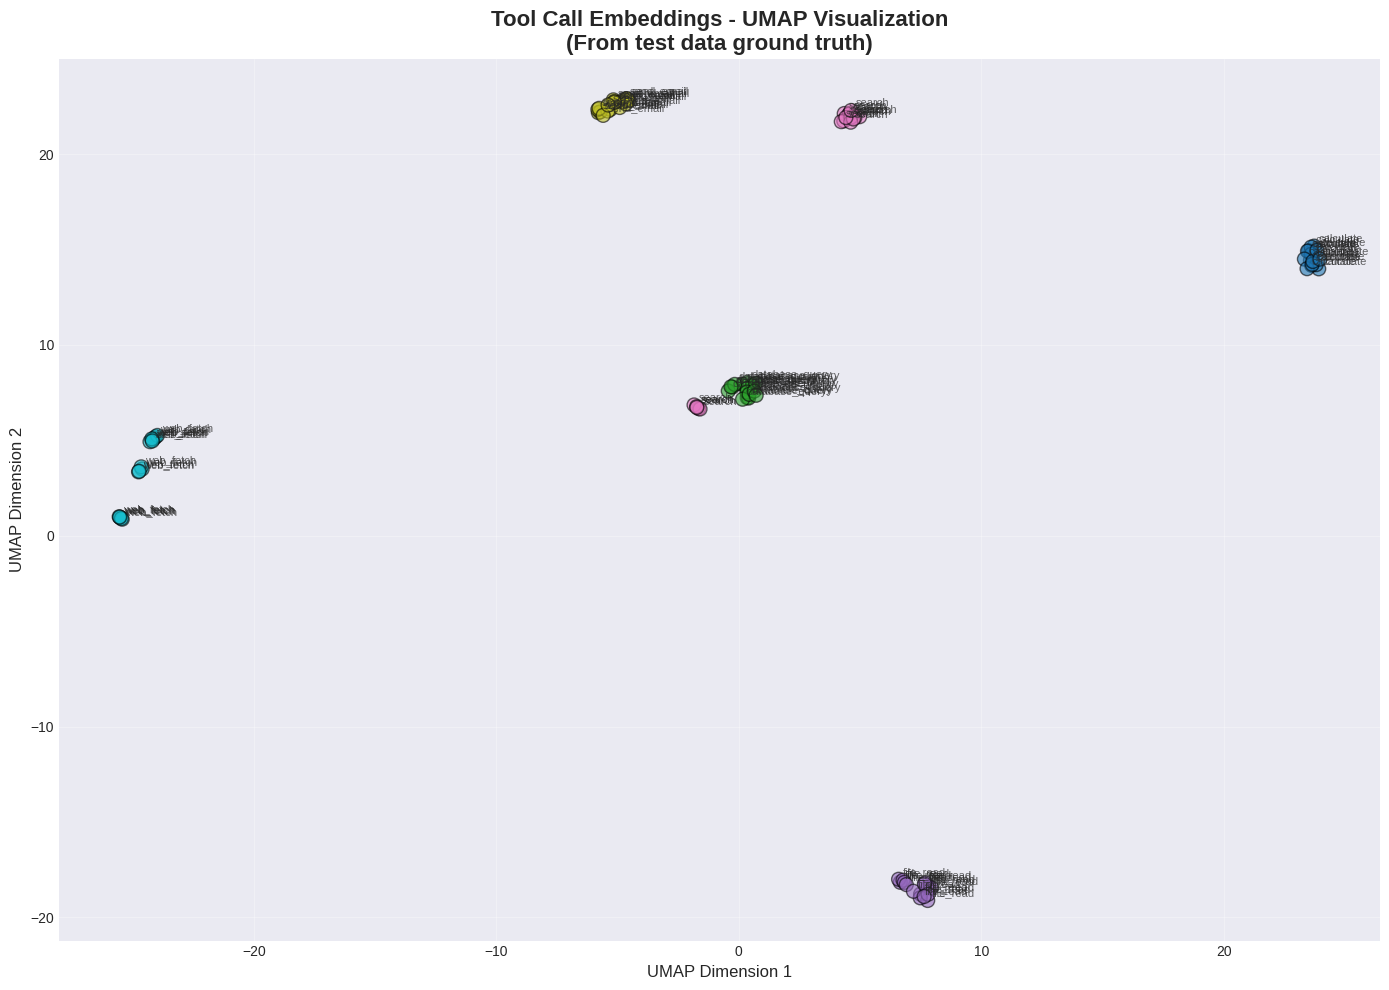

In [9]:
if HAS_UMAP:
    # Apply UMAP
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(tool_calls) - 1))
    embeddings_2d_umap = reducer.fit_transform(tool_call_embeddings)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    scatter = ax.scatter(
        embeddings_2d_umap[:, 0],
        embeddings_2d_umap[:, 1],
        s=100,
        alpha=0.6,
        c=colors,
        cmap='tab10',
        edgecolors='black',
        linewidths=1
    )
    
    # Add labels
    for i, label in enumerate(tool_call_labels):
        ax.annotate(
            label,
            (embeddings_2d_umap[i, 0], embeddings_2d_umap[i, 1]),
            xytext=(3, 3),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7
        )
    
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax.set_title('Tool Call Embeddings - UMAP Visualization\n(From test data ground truth)', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("UMAP not available. Skipping UMAP visualization.")

## 5. Clustering Analysis

Let's use hierarchical clustering to identify tool groups.

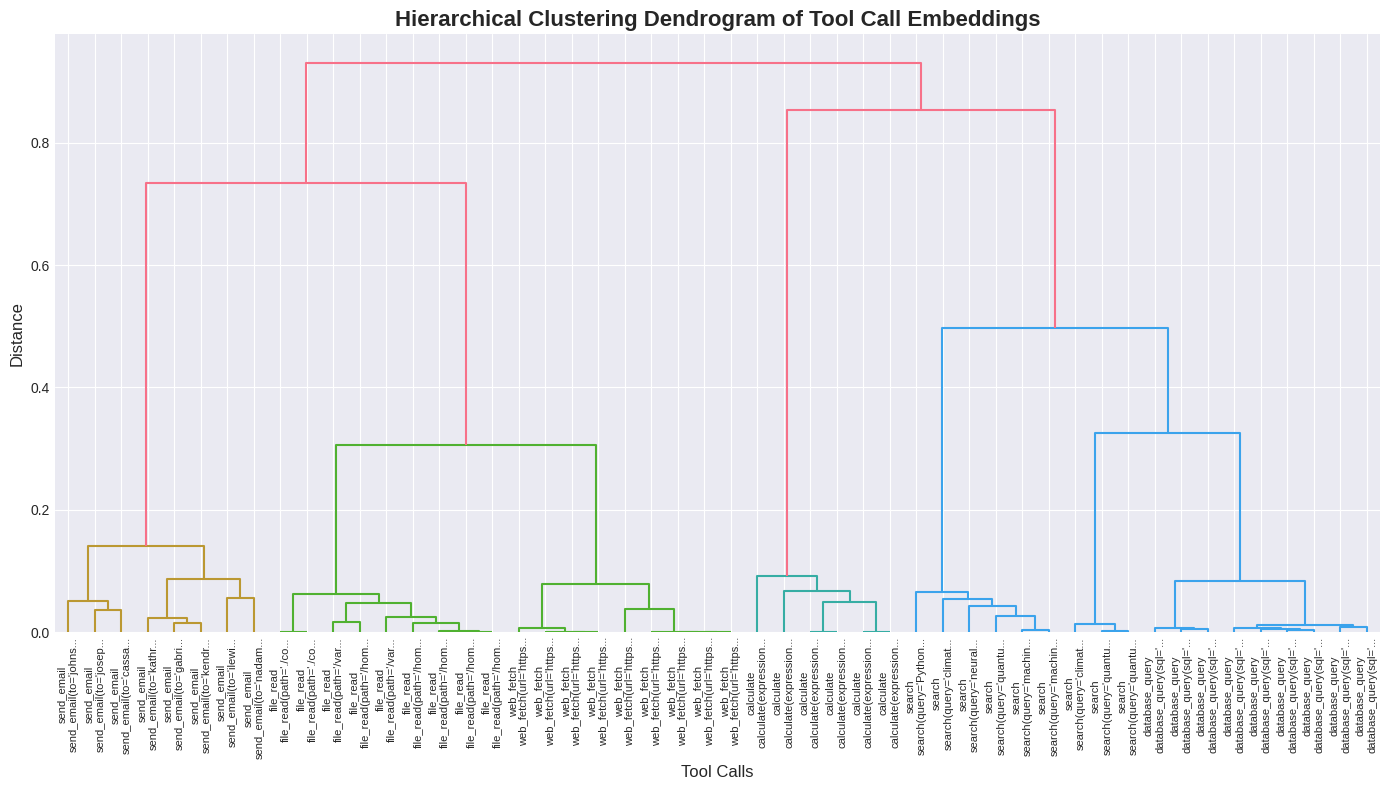

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute distance matrix (using cosine distance)
distance_matrix = pdist(tool_call_embeddings, metric='cosine')

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot dendrogram (sample if too many)
if len(tool_calls) > 50:
    # Sample for visualization
    sample_indices = np.linspace(0, len(tool_calls)-1, 50, dtype=int)
    sample_linkage = linkage(pdist(tool_call_embeddings[sample_indices], metric='cosine'), method='ward')
    sample_labels = [f"{tool_call_labels[i]}\n{tool_calls[i][:20]}..." for i in sample_indices]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    dendrogram(sample_linkage, labels=sample_labels, leaf_rotation=90, leaf_font_size=8, ax=ax)
else:
    fig, ax = plt.subplots(figsize=(14, 8))
    labels = [f"{label}\n{call[:25]}..." if len(call) > 25 else f"{label}\n{call}" 
              for call, label in zip(tool_calls, tool_call_labels)]
    dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=7, ax=ax)

ax.set_title('Hierarchical Clustering Dendrogram of Tool Call Embeddings', fontsize=16, fontweight='bold')
ax.set_xlabel('Tool Calls', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

## 6. K-Means Clustering

Let's also try K-means clustering to identify distinct groups.

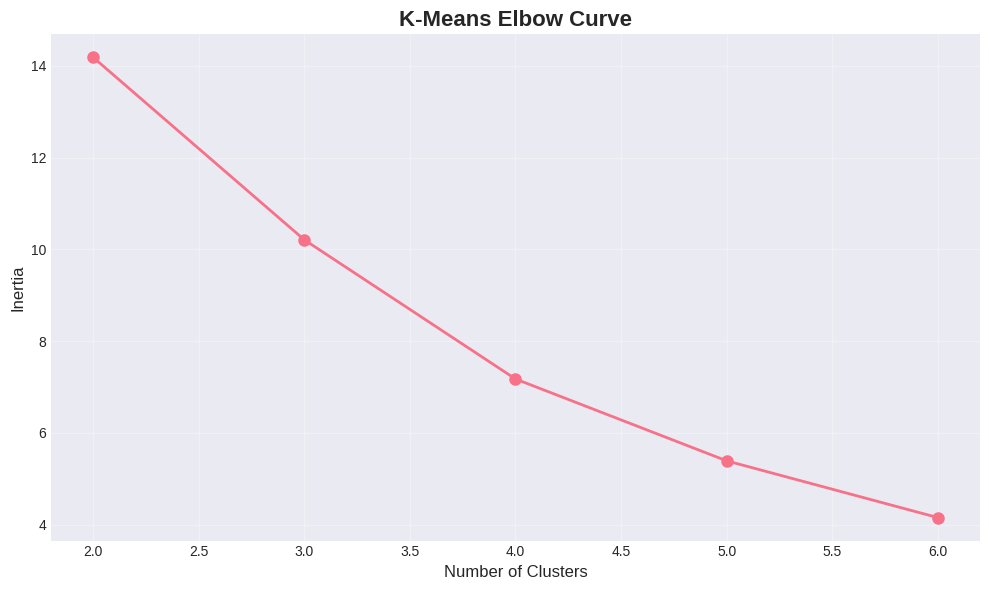


Tool Clusters (sample):
          Tool                                             Tool Call  Cluster
    send_email send_email(to='kathryn88@example.org', subject='Fo...        4
     calculate                   calculate(expression='(5 + 3) * 2')        1
database_query database_query(sql='SELECT * FROM transactions LIM...        2
database_query database_query(sql='SELECT * FROM products LIMIT 8...        2
        search search(query='climate change', max_results=14, dat...        3
     web_fetch web_fetch(url='https://api.github.com/users', meth...        0
     web_fetch web_fetch(url='https://api.github.com/users', meth...        0
     file_read file_read(path='/var/log/app.log', encoding='utf-1...        5
     web_fetch web_fetch(url='https://jsonplaceholder.typicode.co...        0
     file_read file_read(path='./config.json', encoding='latin-1'...        5
     calculate                     calculate(expression='sin(pi/2)')        1
     file_read file_read(path='data/inp

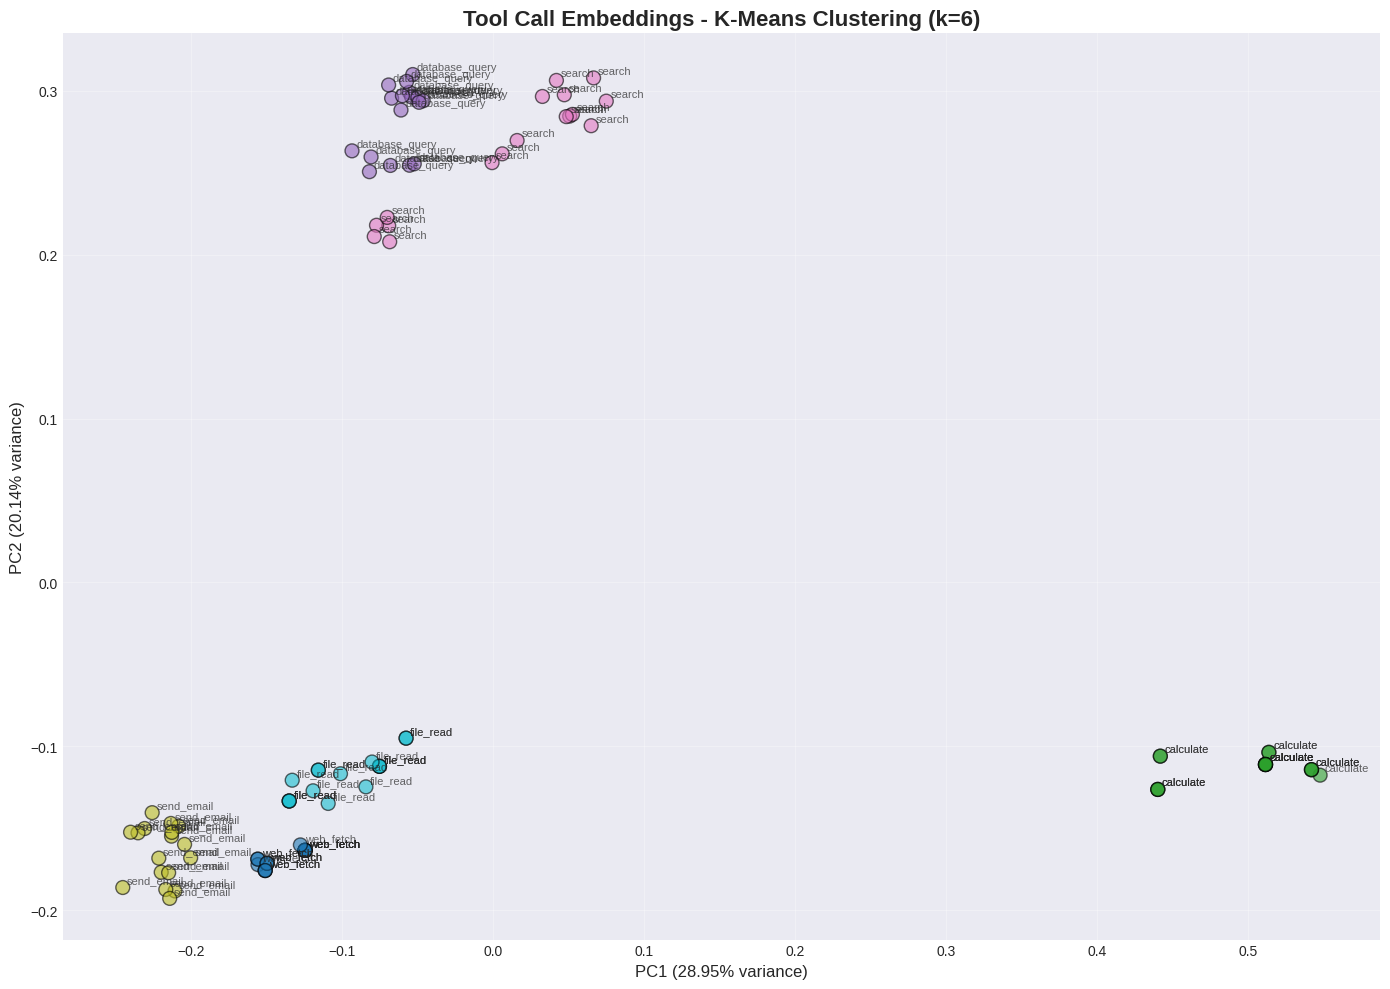

In [11]:
from sklearn.cluster import KMeans

# Try different numbers of clusters
n_clusters_range = range(2, min(num_tools + 1, 10))
inertias = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(tool_call_embeddings)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(list(n_clusters_range), inertias, marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Inertia', fontsize=12)
ax.set_title('K-Means Elbow Curve', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Use optimal number of clusters (you can adjust this)
optimal_clusters = num_tools  # Use number of tools as clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(tool_call_embeddings)

# Create a DataFrame for easier analysis
df_clusters = pd.DataFrame({
    'Tool': tool_call_labels,
    'Tool Call': [call[:50] + "..." if len(call) > 50 else call for call in tool_calls],
    'Cluster': cluster_labels
})
print("\nTool Clusters (sample):")
print(df_clusters.head(20).to_string(index=False))

# Visualize clusters in PCA space
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    s=100,
    alpha=0.6,
    c=cluster_labels,
    cmap='tab10',
    edgecolors='black',
    linewidths=1
)

# Add labels
for i, label in enumerate(tool_call_labels):
    ax.annotate(
        label,
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        alpha=0.7
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title(f'Tool Call Embeddings - K-Means Clustering (k={optimal_clusters})', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()